<a href="https://colab.research.google.com/github/NiallJeffrey/MomentNetworks/blob/evidence/bayesian_evidence_entropy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import time

import sys
from scipy.integrate import quad, dblquad
from scipy.stats import norm
from scipy.integrate import simps
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, Input
from tensorflow.keras.layers import concatenate, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.activations import softmax
from tensorflow.keras import optimizers

import gc

# Define prior and likelihood

In [ ]:
def log_prior_m1(theta):
    m, b = theta
    if -0.2 < m < 0.2 and -10. < b < 60.0:
        return -np.log(.4*70.)
    return -np.inf

def log_prior_m0(b):
    if -10. < b < 60.0:
        return -np.log(70.)
    return -np.inf

def log_likelihood(theta, x, y, ystd):
    m, b = theta
    mu = m * x + b
    return  -0.5 * np.sum(((y - mu)/ystd) ** 2.) \
           - 0.5 * len(ystd) * np.log(np.pi * 2) \
           - 0.5 * np.sum(np.log(ystd**2.))

def model_probability(x,y,ystd):
  model_1 = dblquad(lambda m, b: np.exp(log_prior_m1([m,b]) + log_likelihood([m,b], x,y,ystd)),
              -10,60, -0.2,0.2)[0]  
  model_0 = quad(lambda b: np.exp(log_prior_m0(b) + \
                                log_likelihood([0.,b], x,y,ystd)),
              -10,60)[0]

  return np.array([model_1/(model_1 + model_0), model_0/(model_1 + model_0)])

In [ ]:
print('Prior normalize test: ', dblquad(lambda m, b: np.exp(log_prior_m1([m,b])),
        -15,65, -0.25,0.25)[0])

print('Prior normalize test: ', quad(lambda b: np.exp(log_prior_m0(b)),
        -15,65)[0])

print(r'p(d|$\theta$) normalize test: ',
      dblquad(lambda y_0, y_1: np.exp(log_likelihood([0.1,10],
                                                     np.array([0, 1]),
                                                     np.array([y_0, y_1]),
                                                     np.array([10., 10.]))),
        -500,500,-500,500)[0])

Prior normalize test:  0.9999999999999998
Prior normalize test:  0.9999999999999996
p(d|$\theta$) normalize test:  1.0000000000229905


In [ ]:
0. * tf.math.log(0.)

<tf.Tensor: shape=(), dtype=float32, numpy=nan>

In [ ]:
output = tf.constant([0.0001,0.,1.0,0.2])
tf.print(output)
epsilon =  tf.keras.backend.epsilon()
tf.print(epsilon)
tf.print(output*tf.math.log(tf.clip_by_value(output,epsilon,1)))

[0.0001 0 1 0.2]
1e-07
[-0.000921034 -0 0 -0.321887583]


In [ ]:
model_label = tf.constant([1.,1.,1.,1.])
model_pred = tf.clip_by_value(output,
                                  epsilon * model_label,
                                  1 - epsilon * (1. - model_label))

In [ ]:
model_pred

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([1.e-04, 1.e-07, 1.e+00, 2.e-01], dtype=float32)>

# Generate some synthetic data 

In [ ]:
N = 24
x = np.linspace(0,365*2, N)
ystd = 3*np.linspace(2.5,4., N)**2.

(Text(0.5, 0, '$X\\ (days) $'), Text(0, 0.5, '$Y\\ (data)$'))

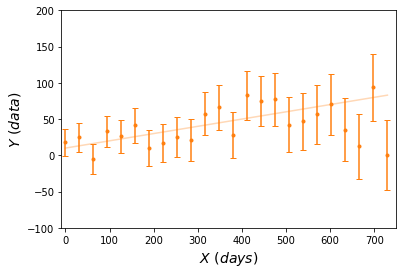

In [ ]:
m_true = 0.1
b_true = 10.

# y = np.random.normal(m_true * x + b_true, ystd)
y = np.array([17.77449586, 24.75139718, -5.29130732, 32.93450198, 26.11140929,
              41.25704121, 10.5234306 , 17.00156764, 24.93071536, 21.02805488,
              57.41378082, 66.20151713, 28.07233675, 83.03543024, 74.83441994,
              77.0407225 , 42.4148314 , 47.08741088, 56.7424198 , 70.31548023,
              35.3467726 , 12.51623015, 93.84094659,  0.58976663])

# y = y*1.8

plt.plot(x, m_true * x + b_true, c='C1' , alpha=0.3)
plt.errorbar(x, y, yerr=ystd, fmt='.C1', capsize=3.45)
plt.xlim(-9, 750), plt.ylim(-100, 200)
plt.xlabel(r'$X\ (days) $', fontsize=14),plt.ylabel(r'$Y\ (data)$', fontsize=14)

# Calculate evidence

## Model 1 -> m free to vary
## Model 0 -> m=0

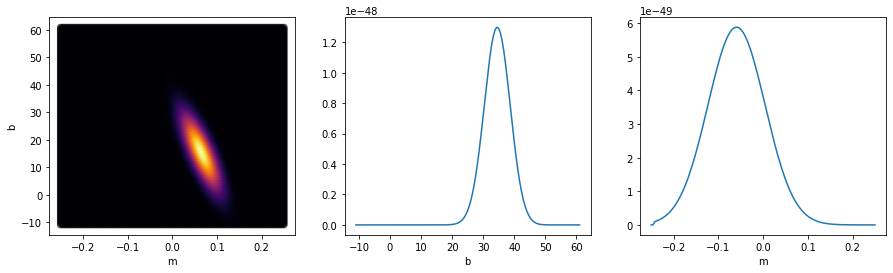

In [ ]:
grid_size = 128
m_array = np.linspace(-0.25,.25,grid_size)
b_array = np.linspace(-11.,61.,grid_size)
theta_0, theta_1 = np.array(np.meshgrid(m_array,b_array))
theta_array = np.vstack([theta_0.flatten(), theta_1.flatten()])

log_prior_array = np.array([log_prior_m1(theta_array[:,i]) \
                         for i in range(theta_array.shape[1])])

unnormalized_log_post_array = np.array([log_likelihood(theta_array[:,i], x,y,ystd) \
                         for i in range(theta_array.shape[1])]) + log_prior_array

_ = plt.figure(figsize=(15,4))
_ = plt.subplot(131)
_ = plt.scatter(theta_0, theta_1, c=np.exp(unnormalized_log_post_array), alpha=0.5,cmap='inferno')
_ = plt.xlabel('m'), plt.ylabel('b')
_ = plt.subplot(132), plt.xlabel('b')
_ = plt.plot(b_array, np.exp(unnormalized_log_post_array).reshape(grid_size,grid_size).sum(axis=0))
_ = plt.subplot(133), plt.xlabel('m')
_ = plt.plot(m_array, np.exp(unnormalized_log_post_array).reshape(grid_size,grid_size).sum(axis=1))
_ = plt.show()

In [ ]:
print('unnormalized posterior integral (marginal likelihood model 1)= ')
model_1 = dblquad(lambda m, b: np.exp(log_prior_m1([m,b]) + log_likelihood([m,b], x,y,ystd)),
              -10,60, -0.2,0.2)[0]
print(model_1)

unnormalized posterior integral (marginal likelihood model 1)= 
5.321314869574318e-50


In [ ]:
log_prior_array0 = np.array([log_prior_m0(b_array[i]) \
                         for i in range(b_array.shape[0])])

unnormalized_log_post_array0 = np.array([log_likelihood([0., b_array[i]], x,y,ystd) \
                         for i in range(b_array.shape[0])]) + log_prior_array0

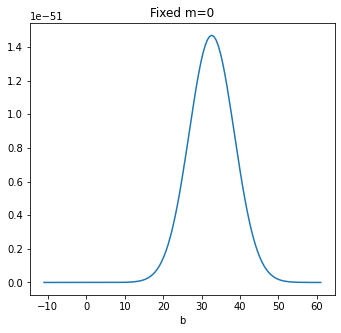

In [ ]:
_ = plt.figure(figsize=(12,5)),
_ = plt.subplot(1,2,1), plt.xlabel('b'),  plt.title('Fixed m=0')
_ = plt.plot(b_array, np.exp(unnormalized_log_post_array0)), plt.show()

In [ ]:
print('unnormalized posterior integral (marginal likelihood model 0)= ')

model_0 = quad(lambda b: np.exp(log_prior_m0(b) + \
                                log_likelihood([0.,b], x,y,ystd)),
              -10,60)[0]
print(model_0)

unnormalized posterior integral (marginal likelihood model 0)= 
2.1569018013236005e-50


In [ ]:
true_bayes_factor = model_1/(model_0)
print(true_bayes_factor)
print(np.log(true_bayes_factor))

2.467110401738665
0.9030475879600375


In [ ]:
model_evidence_true = model_1/(model_1 + model_0)
print(model_evidence_true)

0.711575380034473


# Run evidence net

In [ ]:
from tensorflow.keras import callbacks


epsilon =  tf.keras.backend.epsilon()*0.5


class custom_loss(tf.keras.losses.Loss):

  def call(self, model_label, model_pred):
    model_label = model_label[:,0]
    model_pred = model_pred[:,0]
    model_pred = tf.clip_by_value(model_pred, epsilon, 1. - epsilon)
    cross_ent = - model_label * tf.math.log(model_pred) - \
              (1. - model_label) * tf.math.log(1. - model_pred)
    cross_ent = tf.reduce_mean(cross_ent)
    if tf.math.is_nan(cross_ent):
      tf.print('cross_ent', cross_ent)
      print('NaN error', flush=True)
      tf.print('model_label', model_label)
      tf.print('model_pred', model_pred)
    return cross_ent

y_true = tf.constant([[0, 1], [ 0, 1], [0,1]], dtype=tf.float32)
y_pred = tf.constant([[1e-7, 1-1e-7], [1e-7, 1-1e-7],[1e-10, 1-1e-10]], dtype=tf.float32)
cce = tf.keras.losses.CategoricalCrossentropy()
test_loss = custom_loss()
print(cce(y_true, y_pred).numpy(), test_loss(y_true, y_pred).numpy())


def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer._decayed_lr(tf.float32) # I use ._decayed_lr method instead of .lr
    return lr
    
class simple_leaky:
    """
    A simple MLP with LeakyReLU activation
    """
    
    def __init__(self, input_size, learning_rate=None):
      """
      Initialisation
      :param map_size: size of square image (there are map_size**2 pixels)
      :param learning_rate: learning rate for the optimizer
      """
      self.input_size = input_size
      self.learning_rate = learning_rate

    def model(self):
      print(self.input_size)
      
      input_data = (Input(shape=(self.input_size,)))

      x1 = Dense(100, input_dim=self.input_size, kernel_initializer='normal')(input_data)
      x1 = LeakyReLU(alpha=0.1)(x1)
      x2 = Dense(150, kernel_initializer='normal')(x1)
      x2 = LeakyReLU(alpha=0.1)(x2)
      x3 = Dense(100, kernel_initializer='normal')(x2)
      x3 = LeakyReLU(alpha=0.1)(x3)
      x3 = Dense(100, kernel_initializer='normal')(x3)
      x3 = LeakyReLU(alpha=0.1)(x3)
      x3 = Dense(100, kernel_initializer='normal')(x3)
      x4 = Dense(2, kernel_initializer='normal', activation='softmax')(x3) 
      # lnr = Dense(2, kernel_initializer='normal')(x3) 
      # f = softmax()(lnr)

      dense_model = Model(input_data, x4)

      if self.learning_rate is None:
          lr_schedule = optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-4,
                                                              decay_steps=2000,
                                                              decay_rate=0.9)
          optimizer=optimizers.Adam(learning_rate=lr_schedule)
          lr_metric = get_lr_metric(optimizer)

          dense_model.compile(optimizer=optimizer,
                              loss = custom_loss(),
                              # loss=tf.keras.losses.CategoricalCrossentropy(),
                              # loss='mse',
                              metrics=[lr_metric])
      else:
          dense_model.compile(optimizer=optimizers.Adam(learning_rate=self.learning_rate),
                              loss = custom_loss())
                              # loss=tf.keras.losses.CategoricalCrossentropy())
                              # loss='mse')

      return dense_model

class CustomCallback(callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    keys = list(logs.keys())
    print("Loss: {:.5e}. Val loss: {:.5e}".format(logs['loss'], logs['val_loss']))

1.192093e-07 9.934109e-08


In [ ]:
loc_rescale = np.mean(y)
scale_rescale = 20.*ystd

In [ ]:
model_instance = simple_leaky(N, learning_rate=1e-5)
regression = model_instance.model()
regression.summary()

24
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 24)]              0         
                                                                 
 dense (Dense)               (None, 100)               2500      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 150)               15150     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 150)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               15100     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 100)               0  

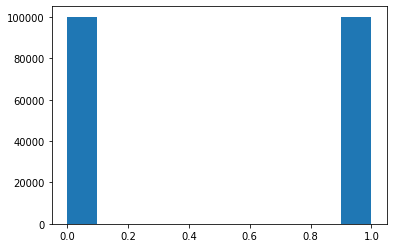

Current prior model ratio (model 1/model 0):  0.9970643
24
Epoch 1/99
NaN error
NaN error
360/360 [==============================] - 6s 13ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 2/99
360/360 [==============================] - 1s 3ms/step - loss: 0.6930 - val_loss: 0.6927
Epoch 3/99
360/360 [==============================] - 1s 3ms/step - loss: 0.6919 - val_loss: 0.6903
Epoch 4/99
360/360 [==============================] - 1s 3ms/step - loss: 0.6846 - val_loss: 0.6736
Epoch 5/99
360/360 [==============================] - 1s 3ms/step - loss: 0.6492 - val_loss: 0.6142
Epoch 6/99
360/360 [==============================] - 1s 4ms/step - loss: 0.5704 - val_loss: 0.5190
Epoch 7/99
360/360 [==============================] - 1s 3ms/step - loss: 0.4838 - val_loss: 0.4463
Epoch 8/99
360/360 [==============================] - 1s 3ms/step - loss: 0.4335 - val_loss: 0.4113
Epoch 9/99
360/360 [==============================] - 1s 3ms/step - loss: 0.4104 - val_loss: 0.3952
Epoch 10/99
360/360 

In [ ]:
epochs_per_step = 100 # number of network epochs per step
validation_fraction = 0.1 # fraction of validation data
n_sample = 200000 # initial number of simulations (samples)

prior_ratio = 1./1.

training_m = np.zeros(shape=((0,)))
training_b = np.zeros(shape=((0,)))
training_model = np.zeros(shape=((0,2)))
training_data = np.zeros((0,N), dtype = 'float')
history_loss = np.zeros(shape=((0,)))
history_val_loss = np.zeros(shape=((0,)))
bayes_factor_corrected_history = []

model_0_fraction = 0.5 # (model_evidence_calc - 0.5)**(1.) + 0.5
model_1_fraction = 1. - model_0_fraction

training_model = np.random.choice(np.arange(2, dtype=np.float32),
                                  p=[model_0_fraction,
                                     model_1_fraction],
                                  size=n_sample) 

_ = plt.hist(training_model), plt.show()

training_b = np.random.uniform(-10,60,n_sample)
training_m = np.random.uniform(-0.2,0.2,n_sample)
training_m = training_model * training_m

training_data = np.zeros((n_sample,N), dtype = 'float')
for j in range(n_sample):
    training_data[j] =  np.random.normal(training_m[j] * x + training_b[j],
                                         ystd)

print('Current prior model ratio (model 1/model 0): ',
      np.sum(training_model)/np.sum(1 - training_model),
      flush=True)

n_validation = int(validation_fraction*training_model.shape[0])

regression = model_instance.model()

prior_weighting = np.where(training_model>0, prior_ratio, 1)
prior_weighting /= np.mean(prior_weighting)

history = regression.fit((0.5+(training_data[:-n_validation]-loc_rescale)/scale_rescale),
                              np.atleast_2d([training_model[:-n_validation],
                                             1-training_model[:-n_validation]]).T,
                         sample_weight=prior_weighting[:-n_validation],
                              epochs =epochs_per_step-1,batch_size =500, shuffle=True,
                              validation_data = ((0.5+(training_data[-n_validation:]-loc_rescale)/scale_rescale),
                                                 np.atleast_2d([training_model[-n_validation:],
                                                                1. -training_model[-n_validation:]]).T,
                                                 prior_weighting[-n_validation:]),
                         verbose=1)


network_model_1_posterior = regression.predict(np.atleast_2d(0.5+(y-loc_rescale)/scale_rescale))[0][0]

print(network_model_1_posterior)
network_posterior_ratio = network_model_1_posterior/(1.-network_model_1_posterior)
print(network_posterior_ratio)
  
bayes_factor = network_posterior_ratio/prior_ratio
print('Network model 1 posterior: ', network_model_1_posterior)
print('Network posterior ratio: ', network_posterior_ratio)
print('Training prior ratio: ', prior_ratio)
print('Corrected Bayes factor: ', bayes_factor)
print('Corrected evidence model 1: ', bayes_factor/(bayes_factor+1))


In [ ]:
network_model_1_posterior = regression.predict(np.atleast_2d(0.5+(y-loc_rescale)/scale_rescale))[0][0]

print(network_model_1_posterior)
network_posterior_ratio = network_model_1_posterior/(1.-network_model_1_posterior)
print(network_posterior_ratio)
  
bayes_factor = network_posterior_ratio/prior_ratio
print('Network model 1 posterior: ', network_model_1_posterior)
print('Network posterior ratio: ', network_posterior_ratio)
print('Training prior ratio: ', prior_ratio, '(1 /',1/prior_ratio,')')
print('Corrected Bayes factor: ', bayes_factor, np.log(bayes_factor))
print('Corrected evidence model 1: ', bayes_factor/(bayes_factor+1))

0.7128671
2.482707604751301
Network model 1 posterior:  0.7128671
Network posterior ratio:  2.482707604751301
Training prior ratio:  1.0 (1 / 1.0 )
Corrected Bayes factor:  2.482707604751301 0.9093497407321849
Corrected evidence model 1:  0.7128670811653137


# Compare against large batch of true model probability calculations

In [ ]:
n_test_calc = 2000
validation_data = training_data[-n_test_calc:]
validation_data_rescaled = 0.5+(validation_data-loc_rescale)/scale_rescale
validation_model = np.atleast_2d([training_model[-n_test_calc:], 1. -training_model[-n_test_calc:]]).T
validation_prediction = regression.predict(validation_data_rescaled)
validation_prediction_corrected = (validation_prediction[:,0]/(1-validation_prediction[:,0]))/prior_ratio
validation_prediction_corrected = validation_prediction_corrected/(validation_prediction_corrected+1)
validation_prediction_corrected = np.array([validation_prediction_corrected,1-validation_prediction_corrected]).T

NameError: ignored

In [ ]:
prior_ratio

1.0

In [ ]:
model_post_validation = np.array([model_probability(x,validation_data[i],ystd) for i in range(validation_data.shape[0])])

print(np.mean(validation_prediction[:,0]), np.mean(validation_prediction[:,1]))
print(np.mean(model_post_validation[:,0]), np.mean(model_post_validation[:,1]))

0.5076632 0.4923368
0.5053182139943764 0.4946817860056237


In [ ]:
np.min(model_post_validation[:,0]/model_post_validation[:,1])

0.1266662624891786

In [ ]:
validation_prediction_corrected.shape

(2000, 2)

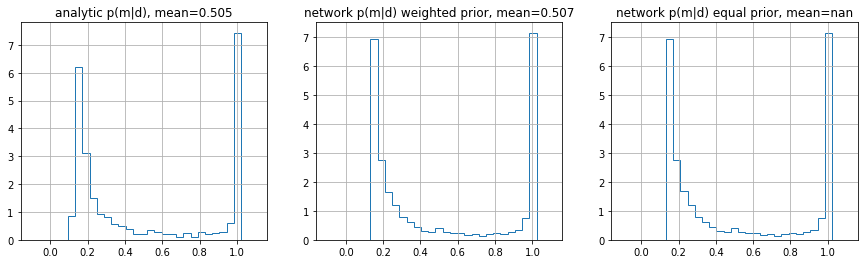

In [ ]:
_ = plt.figure(figsize=(15,4))
_ = plt.subplot(131), plt.grid()
_ = plt.title('analytic p(m|d), mean=' + str(model_post_validation.T[0].mean())[:5])
_ = plt.hist(model_post_validation[:,0], histtype='step',
             bins=np.linspace(-0.1,1.1,32), density=True)
_ = plt.subplot(132), plt.grid()
_ = plt.title('network p(m|d) weighted prior, mean=' + str(validation_prediction.T[0].mean())[:5])
_ =  plt.hist(validation_prediction[:,0], histtype='step',
              bins=np.linspace(-0.1,1.1,32), density=True)
_ = plt.subplot(133), plt.grid()
_ = plt.title('network p(m|d) equal prior, mean=' + str(validation_prediction_corrected.T[0].mean())[:5])
_ =  plt.hist(validation_prediction_corrected[:,0], histtype='step',
              bins=np.linspace(-0.1,1.1,32), density=True)
# _ = plt.legend(), plt.yscale('log')

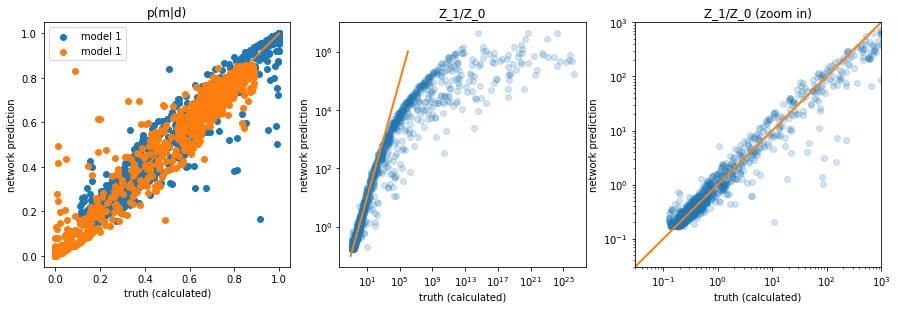

In [ ]:
_ = plt.figure(figsize=(15,4.5))
_ = plt.subplot(131), plt.title('p(m|d)'),
_ = plt.scatter(model_post_validation[:,0], validation_prediction_corrected[:,0], label ='model 1')
_ = plt.scatter(model_post_validation[:,1], validation_prediction_corrected[:,1], label ='model 1'), plt.legend()
_ = plt.plot([0,1],[0,1], lw=2, c='C1')
_ = plt.xlabel('truth (calculated)'), plt.ylabel('network prediction')
_ = plt.subplot(132), plt.title('Z_1/Z_0')
_ = plt.scatter(model_post_validation[:,0]/model_post_validation[:,1],
                validation_prediction_corrected[:,0]/validation_prediction_corrected[:,1], alpha=0.2)
_ = plt.plot([1e-1,1e6],[1e-1,1e6], lw=2, c='C1')
_ = plt.xlabel('truth (calculated)'), plt.ylabel('network prediction')
_ = plt.loglog()
_ = plt.subplot(133), plt.title('Z_1/Z_0 (zoom in)')
_ = plt.ylim(3e-2,1e3),plt.xlim(3e-2,1e3)
_ = plt.scatter(model_post_validation[:,0]/model_post_validation[:,1],
                validation_prediction_corrected[:,0]/validation_prediction_corrected[:,1], alpha=0.2)
_ = plt.plot([1e-4,1e6],[1e-4,1e6], lw=2, c='C1')
_ = plt.xlabel('truth (calculated)'), plt.ylabel('network prediction')
_ = plt.loglog()

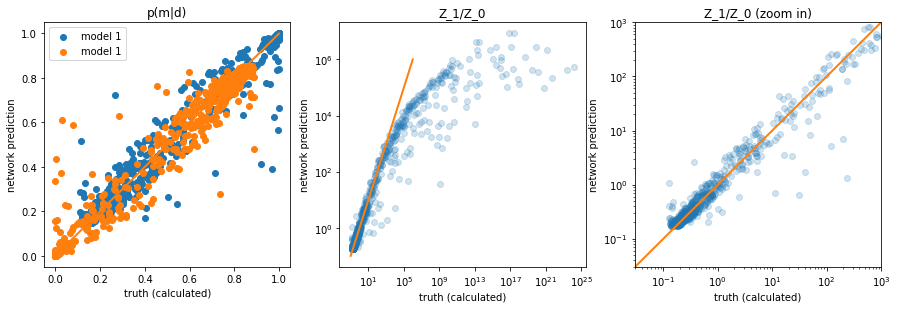

In [ ]:
_ = plt.figure(figsize=(15,4.5))
_ = plt.subplot(131), plt.title('p(m|d)'),
_ = plt.scatter(model_post_validation[:,0], validation_prediction_corrected[:,0], label ='model 1')
_ = plt.scatter(model_post_validation[:,1], validation_prediction_corrected[:,1], label ='model 1'), plt.legend()
_ = plt.plot([0,1],[0,1], lw=2, c='C1')
_ = plt.xlabel('truth (calculated)'), plt.ylabel('network prediction')
_ = plt.subplot(132), plt.title('Z_1/Z_0')
_ = plt.scatter(model_post_validation[:,0]/model_post_validation[:,1],
                validation_prediction_corrected[:,0]/validation_prediction_corrected[:,1], alpha=0.2)
_ = plt.plot([1e-1,1e6],[1e-1,1e6], lw=2, c='C1')
_ = plt.xlabel('truth (calculated)'), plt.ylabel('network prediction')
_ = plt.loglog()
_ = plt.subplot(133), plt.title('Z_1/Z_0 (zoom in)')
_ = plt.ylim(3e-2,1e3),plt.xlim(3e-2,1e3)
_ = plt.scatter(model_post_validation[:,0]/model_post_validation[:,1],
                validation_prediction_corrected[:,0]/validation_prediction_corrected[:,1], alpha=0.2)
_ = plt.plot([1e-4,1e6],[1e-4,1e6], lw=2, c='C1')
_ = plt.xlabel('truth (calculated)'), plt.ylabel('network prediction')
_ = plt.loglog()

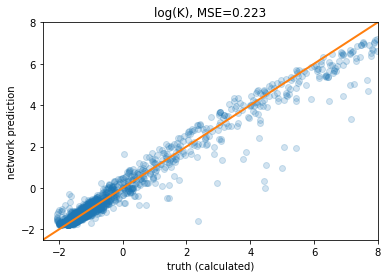

In [ ]:
_ = plt.ylim(-2.5,8),plt.xlim(-2.5,8)
log_K_numerical = np.log(model_post_validation[:,0]/model_post_validation[:,1])
log_K_net = np.log(validation_prediction_corrected[:,0]/validation_prediction_corrected[:,1])
log_K_net = log_K_net[np.where(log_K_numerical<8)]
log_K_numerical = log_K_numerical[np.where(log_K_numerical<8)]
_ = plt.title('log(K), MSE=' + str(np.mean((log_K_numerical-log_K_net)**2.))[:5])
_ = plt.scatter(log_K_numerical,log_K_net, alpha=0.2)
_ = plt.plot([-5,1e6],[-5,1e6], lw=2, c='C1')
_ = plt.xlabel('truth (calculated)'), plt.ylabel('network prediction')

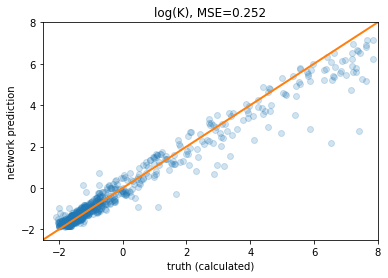

In [ ]:
_ = plt.ylim(-2.5,8),plt.xlim(-2.5,8)
log_K_numerical = np.log(model_post_validation[:,0]/model_post_validation[:,1])
log_K_net = np.log(validation_prediction_corrected[:,0]/validation_prediction_corrected[:,1])
log_K_net = log_K_net[np.where(log_K_numerical<8)]
log_K_numerical = log_K_numerical[np.where(log_K_numerical<8)]
_ = plt.title('log(K), MSE=' + str(np.mean((log_K_numerical-log_K_net)**2.))[:5])
_ = plt.scatter(log_K_numerical,log_K_net, alpha=0.2)
_ = plt.plot([-5,1e6],[-5,1e6], lw=2, c='C1')
_ = plt.xlabel('truth (calculated)'), plt.ylabel('network prediction')

In [ ]:
plt.title('log(K) (zoom in)')
_ = plt.ylim(-2.5,8),plt.xlim(-2.5,8)
_ = plt.scatter(np.log(model_post_validation[:,0]/model_post_validation[:,1]),
                np.log(validation_prediction_corrected[:,0]/validation_prediction_corrected[:,1]), alpha=0.2)
_ = plt.plot([-5,1e6],[-5,1e6], lw=2, c='C1')
_ = plt.xlabel('truth (calculated)'), plt.ylabel('network prediction')

In [ ]:
_ = plt.figure(figsize=(15,4.5))
_ = plt.subplot(131), plt.title('p(m|d)'),
_ = plt.scatter(model_post_validation[:,0], validation_prediction[:,0], label ='model 1')
_ = plt.scatter(model_post_validation[:,1], validation_prediction[:,1], label ='model 1'), plt.legend()
_ = plt.plot([0,1],[0,1], lw=2, c='C1')
_ = plt.xlabel('truth (calculated)'), plt.ylabel('network prediction')
_ = plt.subplot(132), plt.title('Z_1/Z_0')
_ = plt.scatter(model_post_validation[:,0]/model_post_validation[:,1],
                validation_prediction_corrected[:,0]/validation_prediction_corrected[:,1], alpha=0.2)
_ = plt.plot([1e-1,1e6],[1e-1,1e6], lw=2, c='C1')
_ = plt.xlabel('truth (calculated)'), plt.ylabel('network prediction')
_ = plt.loglog()
_ = plt.subplot(133), plt.title('Z_1/Z_0 (zoom in)')
_ = plt.ylim(3e-2,1e3),plt.xlim(3e-2,1e3)
_ = plt.scatter(model_post_validation[:,0]/model_post_validation[:,1],
                validation_prediction_corrected[:,0]/validation_prediction_corrected[:,1], alpha=0.2)
_ = plt.plot([1e-4,1e6],[1e-4,1e6], lw=2, c='C1')
_ = plt.xlabel('truth (calculated)'), plt.ylabel('network prediction')
_ = plt.loglog()

In [ ]:
plt.xlim(0,5),plt.ylim(0,5)
_ = plt.scatter(model_post_validation[:,0]/model_post_validation[:,1], validation_prediction[:,0]/validation_prediction[:,1], alpha=0.2)
# _ = plt.scatter(model_post_validation[:,0]/model_post_validation[:,1], validation_prediction2[:,0]/validation_prediction2[:,1], alpha=0.2)
_ = plt.plot([1e-4,1e6],[2.4e-4,2.4e6], lw=2, c='C3')
_ = plt.plot([1e-4,1e6],[1e-4,1e6], lw=2, c='C1')
_ = plt.xlabel('truth (calculated)'), plt.ylabel('network prediction')